In [1]:
import pandas as pd
import mplfinance as mpf
import datetime
import requests
import os
import json
import mplfinance as mpf
import random

In [2]:
uri = 'http://192.168.100.111:3334/candle5'
headers = {'Content-Type': 'application/json'}

In [3]:
year = 2021
month = 8
day = 1

startDate = datetime.datetime(year, month, day, 0, 0, 0, 0)
endDate = startDate + datetime.timedelta(days=1)
start = str(startDate.timestamp()*1000).replace(".0", "")
end = str(endDate.timestamp()*1000).replace(".0", "")

data = {}

In [10]:
retry = False
while startDate.day != 29:
    if retry == False:
        startDate = startDate + datetime.timedelta(days=1)
        endDate = startDate + datetime.timedelta(days=1)
        start = str(startDate.timestamp()*1000).replace(".0", "")
        end = str(endDate.timestamp()*1000).replace(".0", "")
    retry = False
    query = f'{uri}?from={start}&to={end}'
    result = requests.get(query, headers=headers)
    if result.status_code == requests.codes.ok and len(result.text) > 3:
        ticks = json.loads(result.text)['ticks']
        for tick in ticks:
            data[tick['timestamp']] = (float(tick['high']), float(tick['low']), float(tick['first']), float(tick['last']), datetime.datetime.fromtimestamp(float(tick['timestamp'])/1000))
            if startDate.month != month:
                month = startDate.month
                #save_dict_to_file(data, f'candle_{startDate.year}-{startDate.month}_temp')
    else:
        print(f'Connection Failed: {result.status_code}, content:{result.text}')
        retry = True
        if result.status_code == requests.codes.ok:
            retry = False

Connection Failed: 200, content:[]


In [11]:
len(data)

3904

In [12]:
df = pd.DataFrame.from_dict(data, orient='index', columns = ['High', 'Low', 'Open', 'Close', 'Timestamp'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [13]:
df

,High,Low,Open,Close
Timestamp,,,,
2021-08-07 09:40:00,4731426.0,4723000.0,4727555.0,4725663.0
2021-08-07 09:45:00,4729999.0,4720001.0,4725595.0,4725175.0
2021-08-07 09:50:00,4734769.0,4724727.0,4727681.0,4733373.0
2021-08-07 09:55:00,4757014.0,4732538.0,4733331.0,4753948.0
2021-08-07 10:00:00,4769694.0,4747002.0,4753514.0,4760000.0
...,...,...,...,...
2021-08-28 17:20:00,5372469.0,5359000.0,5372067.0,5365552.0
2021-08-28 17:25:00,5369463.0,5361252.0,5365712.0,5367061.0
2021-08-28 17:30:00,5368404.0,5363669.0,5365090.0,5366831.0


In [14]:
dataFrame = df.copy().sort_index()

In [38]:
dataFrame

,High,Low,Open,Close
Timestamp,,,,
2021-08-07 09:40:00,4731426.0,4723000.0,4727555.0,4725663.0
2021-08-07 09:45:00,4729999.0,4720001.0,4725595.0,4725175.0
2021-08-07 09:50:00,4734769.0,4724727.0,4727681.0,4733373.0
2021-08-07 09:55:00,4757014.0,4732538.0,4733331.0,4753948.0
2021-08-07 10:00:00,4769694.0,4747002.0,4753514.0,4760000.0
...,...,...,...,...
2021-08-28 17:20:00,5372469.0,5359000.0,5372067.0,5365552.0
2021-08-28 17:25:00,5369463.0,5361252.0,5365712.0,5367061.0
2021-08-28 17:30:00,5368404.0,5363669.0,5365090.0,5366831.0


In [44]:
data = {}
SPAN=60
for index in range(0, len(dataFrame)-3):
    if dataFrame[index+1:index+2].index[0] - dataFrame[index:index+1].index[0] < datetime.timedelta(minutes=SPAN) and dataFrame[index+1:index+2].index[0] - dataFrame[index:index+1].index[0] >= datetime.timedelta(minutes=5):
        missingCount = (dataFrame[index+1:index+2].index[0] - dataFrame[index:index+1].index[0])/datetime.timedelta(minutes=5)
        for count in range(0, int(missingCount)):
            timestamp = dataFrame[index:index+1].index[0]+ datetime.timedelta(minutes=5)
            if dataFrame[index:index+1].Close.values[0] > dataFrame[index+1:index+2].Open.values[0]:
                diff = (dataFrame[index:index+1].Close.values[0] - dataFrame[index+1:index+2].Open.values[0])/missingCount
                openValue = dataFrame[index:index+1].Close.values[0] - diff * count
                closeValue = dataFrame[index:index+1].Close.values[0] - diff * (count+1)
                High = openValue * (1+abs(random.gauss(0, 0.0005)))
                Low = closeValue * (1-abs(random.gauss(0, 0.0005)))
            else:
                diff = (dataFrame[index+1:index+2].Open.values[0] - dataFrame[index:index+1].Close.values[0])/missingCount
                openValue = dataFrame[index:index+1].Close.values[0] + diff * count
                closeValue = dataFrame[index:index+1].Close.values[0] + diff * (count+1)
                High = closeValue * (1+abs(random.gauss(0, 0.0005)))
                Low = openValue * (1-abs(random.gauss(0, 0.0005)))
        data[timestamp] = [High, Low,openValue, closeValue, timestamp]
    else:
        continue

In [41]:
df = pd.DataFrame.from_dict(data, orient='index', columns = ['High', 'Low', 'Open', 'Close', 'Timestamp'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [43]:
df

,High,Low,Open,Close
Timestamp,,,,
2021-08-07 09:45:00,4.726170e+06,4.723975e+06,4725663.0,4725595.0
2021-08-07 09:50:00,4.727869e+06,4.724845e+06,4725175.0,4727681.0
2021-08-07 09:55:00,4.735111e+06,4.731651e+06,4733373.0,4733331.0
2021-08-07 10:00:00,4.758908e+06,4.750215e+06,4753948.0,4753514.0
2021-08-07 10:05:00,4.764041e+06,4.759936e+06,4760000.0,4760000.0
...,...,...,...,...
2021-08-28 17:10:00,5.364881e+06,5.357392e+06,5362499.0,5363749.0
2021-08-28 17:15:00,5.368665e+06,5.365116e+06,5366191.0,5365613.0
2021-08-28 17:20:00,5.373126e+06,5.369877e+06,5371515.0,5372067.0


In [46]:
INTERVAL_DAYS = 2
MINUTES_SPAN = 5

totalMinutes = INTERVAL_DAYS * 24 * 60
span  = int(totalMinutes/MINUTES_SPAN)
span

576

In [47]:
dataFrame = df.copy().sort_index()

In [49]:
count = 0
['High', 'Low', 'Open', 'Close']
dataHigh = []
dataLow = []
dataOpen = []
dataClose = []
dataBoaderValue = []
dataDateTime = []

# create Array of arrayt which contain INTERVAL_DAYS candle info
for index in range(0, len(dataFrame) - span -2):
    if dataFrame[index+span:index+span+1].index[0] - dataFrame[index:index+1].index[0] == datetime.timedelta(days=INTERVAL_DAYS):
        dataHigh.append(dataFrame[index:index+span+1].High.values)
        dataLow.append(dataFrame[index:index+span+1].Low.values)
        dataOpen.append(dataFrame[index:index+span+1].Open.values)
        dataClose.append(dataFrame[index:index+span+1].Close.values)
        dataDateTime.append(dataFrame[index:index+span+1].index.values)

In [1]:
import numpy as np
import pandas as pd
import datetime

In [52]:
np.savez_compressed('data/bc_boader_2days_test.npz', High=np.asarray(dataHigh), Low=np.asarray(dataLow), Open=np.asarray(dataOpen), Close=np.asarray(dataClose), DateTime=np.asarray(dataDateTime))

In [81]:
data = np.load('data/bc_boader_2days_test.npz')

In [105]:
data['DateTime']

array([['2021-08-17T03:40:00.000000000', '2021-08-17T03:45:00.000000000',
        '2021-08-17T03:50:00.000000000', ...,
        '2021-08-19T03:30:00.000000000', '2021-08-19T03:35:00.000000000',
        '2021-08-19T03:40:00.000000000'],
       ['2021-08-17T03:45:00.000000000', '2021-08-17T03:50:00.000000000',
        '2021-08-17T03:55:00.000000000', ...,
        '2021-08-19T03:35:00.000000000', '2021-08-19T03:40:00.000000000',
        '2021-08-19T03:45:00.000000000'],
       ['2021-08-17T03:50:00.000000000', '2021-08-17T03:55:00.000000000',
        '2021-08-17T04:00:00.000000000', ...,
        '2021-08-19T03:40:00.000000000', '2021-08-19T03:45:00.000000000',
        '2021-08-19T03:50:00.000000000'],
       ...,
       ['2021-08-26T17:10:00.000000000', '2021-08-26T17:15:00.000000000',
        '2021-08-26T17:20:00.000000000', ...,
        '2021-08-28T17:00:00.000000000', '2021-08-28T17:05:00.000000000',
        '2021-08-28T17:10:00.000000000'],
       ['2021-08-26T17:15:00.000000000', '20

In [151]:
# normalize rate
# try 1: max value of the range
toIndex = len(data['High'])-1
progress = -1
inputData = []
inputDateTime = []
for index in range(0,toIndex):
    
    if int((index/toIndex)*100) != progress:
        progress = int((index/toIndex)*100)
        print(progress)
    highForRange = data['High'][index].max()
    inputData.append([data['High'][index]/highForRange, data['Low'][index]/highForRange, data['Open'][index]/highForRange, data['Close'][index]/highForRange])
    inputDateTime.append(data['DateTime'][index][-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [107]:
dic = dict()

In [120]:
data['DateTime'][0][0]

numpy.datetime64('2021-08-17T03:40:00.000000000')

In [113]:
dic[data['DateTime'][0]] = [0,1,2,3,]

TypeError: unhashable type: 'numpy.ndarray'

In [112]:
dic[0]

KeyError: 0

In [57]:
npInputData = np.array(inputData)

In [59]:
np.save('data/bc_boader_2days_input_anormalized_test', npInputData)

In [3]:
npInputData = np.load(file='data/bc_boader_2days_input_anormalized_test.npy')

In [4]:
import torch

In [5]:
inputData = torch.from_numpy(npInputData).to(torch.float32)

In [7]:
inputData[0:1]

tensor([[[0.9879, 0.9861, 0.9867,  ..., 0.9742, 0.9749, 0.9761],
         [0.9870, 0.9856, 0.9859,  ..., 0.9737, 0.9742, 0.9753],
         [0.9878, 0.9860, 0.9859,  ..., 0.9740, 0.9746, 0.9760],
         [0.9874, 0.9860, 0.9864,  ..., 0.9741, 0.9748, 0.9759]]])

In [12]:
inputData[0:1][0][0].shape

torch.Size([577])

In [67]:
import torch.nn.functional as F
import torch.nn as nn

In [68]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4,16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16,8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*577, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        out = torch.tanh(self.conv1(x))
        out = torch.tanh(self.conv2(out))
        out = out.view(-1, 8*577)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [69]:
model = Net()
model.load_state_dict(torch.load('bc_boader_2days'))

<All keys matched successfully>

In [78]:
out = model(inputData[0:1])

In [84]:
data['High'][0].max()

5147551.561182085

In [100]:
out.detach().numpy()

array([[0.9755611]], dtype=float32)

In [102]:
out.item() * data['High'][0].max()

5021750.972546808

In [137]:
data['High'][0][-1]

5024650.792902715

In [103]:
import mplfinance as mpf

In [152]:
inputDateTime[0]

numpy.datetime64('2021-08-19T03:40:00.000000000')

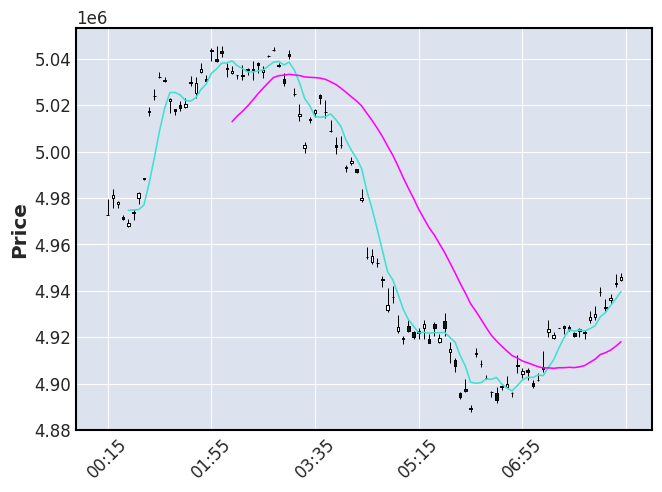

In [154]:
mpf.plot(df[1100:1200], type='candle', mav=(5, 25))

In [155]:
targetDf = df[1100:1200]
meanArray = []
mean5Array = []
trend = 0
boaders = []

for index, row in targetDf.iterrows():
    currentMean = (row.High + row.Low)/2
    meanArray.append(currentMean)

for mean in meanArray:
    index = len(mean5Array)
    if index > 2:
        mean5Value = 0
        for value in meanArray[index-2:index+3]:
            mean5Value += value
        mean5Value = mean5Value/5
        last5Value = mean5Array[-1]
        diff = mean5Value - last5Value
        mean5Array.append(mean5Value)
        if diff > 0:
            if trend == -1:
                boaders.append(([targetDf[index:index+1].index[0]] ,targetDf.iloc[index].Low))
            trend = 1
        else:
            if trend == 1:
                boaders.append(([targetDf[index:index+1].index[0]] ,targetDf.iloc[index].High))
            trend = -1
    else:
        mean5Array.append(mean)

In [156]:
currentBoaderIndex = 0
nextBoaderValues = []
ended = False
for index, row in targetDf.iterrows():
    if index <= boaders[currentBoaderIndex][0][0]:
        nextBoaderValues.append(boaders[currentBoaderIndex][1])
    else:
        while index > boaders[currentBoaderIndex][0][0]:
            if currentBoaderIndex < len(boaders)-1:
                currentBoaderIndex += 1
            else:
                ended = True
                break;
        if ended is True:
            nextBoaderValues.append(-1)
        else:
            nextBoaderValues.append(boaders[currentBoaderIndex][1])

In [157]:
nextBoaderValues

[4967456.719454859,
 4967456.719454859,
 4967456.719454859,
 4967456.719454859,
 4967456.719454859,
 5032097.501829909,
 5032097.501829909,
 5032097.501829909,
 5032097.501829909,
 5032097.501829909,
 5032097.501829909,
 5032097.501829909,
 5018750.041228093,
 5018750.041228093,
 5018750.041228093,
 5018750.041228093,
 5045343.321756629,
 5045343.321756629,
 5045343.321756629,
 5045343.321756629,
 5045343.321756629,
 5045343.321756629,
 5040803.674274612,
 5037995.374676099,
 5033135.962497936,
 5033135.962497936,
 5033135.962497936,
 5033135.962497936,
 5044895.742085427,
 5044895.742085427,
 5044895.742085427,
 5044895.742085427,
 5044895.742085427,
 5036328.723686381,
 5033882.008070837,
 5014879.372676366,
 5014879.372676366,
 5014879.372676366,
 5014879.372676366,
 5014879.372676366,
 5014879.372676366,
 5022348.136442604,
 5022348.136442604,
 4919240.72965121,
 4919240.72965121,
 4919240.72965121,
 4919240.72965121,
 4919240.72965121,
 4919240.72965121,
 4919240.72965121,
 491924

In [158]:
targetDf['BoaderValue'] = nextBoaderValues

/home/cow/python/torch/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
targetDf[40:60]

,High,Low,Open,Close,BoaderValue
Timestamp,,,,,
2021-08-19 03:35:00,5.018440e+06,5.014879e+06,5016552.0,5017906.0,5.014879e+06
2021-08-19 03:40:00,5.024651e+06,5.020459e+06,5024240.0,5023269.0,5.022348e+06
2021-08-19 03:45:00,5.022348e+06,5.014440e+06,5016917.0,5016869.0,5.022348e+06
2021-08-19 03:50:00,5.013437e+06,5.008377e+06,5009050.0,5009050.0,4.919241e+06
2021-08-19 03:55:00,5.006103e+06,4.999129e+06,5003005.0,5001941.0,4.919241e+06
2021-08-19 04:00:00,5.006732e+06,5.001342e+06,5002862.0,5002860.0,4.919241e+06
2021-08-19 04:05:00,4.994130e+06,4.991082e+06,4992883.0,4993336.0,4.919241e+06
2021-08-19 04:10:00,4.997490e+06,4.994239e+06,4994998.0,4995804.0,4.919241e+06
2021-08-19 04:15:00,4.992674e+06,4.990556e+06,4992499.0,4991095.0,4.919241e+06


In [167]:
targetDf[42:43].index[0] == inputDateTime[1]

True